# Advanced ML

## Student Bayes Net

Bayesian Belief Network or Bayesian Network or Belief Network is a Probabilistic Graphical Model (PGM) that represents conditional dependencies between random variables through a Directed Acyclic Graph (DAG).Bayesian Networks are applied in many fields. For example, disease diagnosis, optimized web search, spam filtering, gene regulatory networks, etc.

We will build a Students Bayes network.

<img src="student_net.png" width=50% />

In [1]:
import networkx as nx
import pylab as plt
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianModel

## A - Set up the model

### 1. Set the structure

In [2]:
model = BayesianModel([('diff', 'grade'), ('intel', 'grade'), ('intel', 'sat'), ('grade', 'letter')])

### 2. Visualize the model

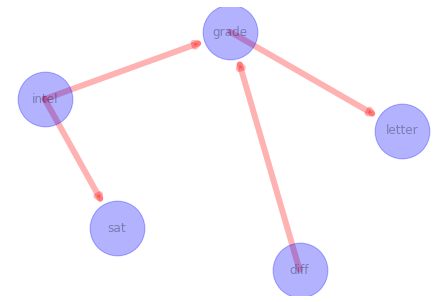

In [3]:
options = {
    'node_color': 'b',
    'node_size': 3000,
    'width': 6,
    'alpha':0.3,
    'edge_color':'r'
}

nx.draw(model, with_labels=True, **options)
plt.show()

###  3.Set up the relationships (the CPDs)

In [4]:
cpd_diff = TabularCPD('diff',2,[[0.6,0.4]]);
cpd_intel = TabularCPD('intel',2,[[0.7,0.3]]);

cpd_grade = TabularCPD('grade', 3, [[0.3, 0.05, 0.9, 0.5],
                                    [0.4, 0.25, 0.08, 0.3],
                                    [0.3, 0.7, 0.02, 0.2]],
                                 evidence=['intel', 'diff'], evidence_card=[2, 2])

cpd_sat = TabularCPD('sat', 2, [[0.95, 0.2],
                                    [0.05, 0.8]],
                                 evidence=['intel'], evidence_card=[2])

cpd_letter = TabularCPD('letter', 2, [[0.1, 0.4, 0.99],
                                    [0.9, 0.6,0.01]],
                                 evidence=['grade'], evidence_card=[3])

### 4. Add relationships to the model

In [5]:
model.add_cpds(cpd_diff,cpd_intel,cpd_grade, cpd_sat, cpd_letter)

### 5. Examine the structure of your graph

In [6]:
model.get_cpds()

[<TabularCPD representing P(diff:2) at 0x18cdc406808>,
 <TabularCPD representing P(intel:2) at 0x18cdc4067c8>,
 <TabularCPD representing P(grade:3 | intel:2, diff:2) at 0x18cdc406888>,
 <TabularCPD representing P(sat:2 | intel:2) at 0x18cdc406948>,
 <TabularCPD representing P(letter:2 | grade:3) at 0x18cdc4069c8>]

### 6. Find active trail nodes

In [7]:
#path of influence
model.active_trail_nodes('grade')

{'grade': {'diff', 'grade', 'intel', 'letter', 'sat'}}

In [8]:
model.active_trail_nodes('intel')

{'intel': {'grade', 'intel', 'letter', 'sat'}}

### 7. Find local independencies

In [9]:
model.local_independencies('grade')

(grade _|_ sat | diff, intel)

In [10]:
model.local_independencies('intel')

(intel _|_ diff)

### 8. Get all independencies

In [11]:
model.get_independencies()

(diff _|_ sat, intel)
(diff _|_ intel | sat)
(diff _|_ letter | grade)
(diff _|_ sat | intel)
(diff _|_ letter | sat, grade)
(diff _|_ sat | letter, intel)
(diff _|_ sat, letter | grade, intel)
(diff _|_ letter | sat, grade, intel)
(diff _|_ sat | letter, grade, intel)
(grade _|_ sat | intel)
(grade _|_ sat | diff, intel)
(grade _|_ sat | letter, intel)
(grade _|_ sat | diff, letter, intel)
(intel _|_ diff)
(intel _|_ letter | grade)
(intel _|_ diff | sat)
(intel _|_ letter | diff, grade)
(intel _|_ letter | sat, grade)
(intel _|_ letter | diff, grade, sat)
(sat _|_ diff)
(sat _|_ letter | grade)
(sat _|_ diff, letter, grade | intel)
(sat _|_ letter | diff, grade)
(sat _|_ letter, grade | diff, intel)
(sat _|_ diff, grade | letter, intel)
(sat _|_ diff, letter | grade, intel)
(sat _|_ grade | diff, letter, intel)
(sat _|_ letter | diff, grade, intel)
(sat _|_ diff | letter, grade, intel)
(letter _|_ diff, sat, intel | grade)
(letter _|_ sat | intel)
(letter _|_ sat, intel | diff, grade

## B - Making inferences

### 1. Marginal Inference 

Finding the probability distribution of a specific variable. 

For instance, given a graph with variables A, B, C, and D, where A takes values 1, 2, and 3, find p(A=1), p(A=2) and p(A=3).

In [12]:
from pgmpy.inference import VariableElimination

In [13]:
infer = VariableElimination(model)

In [14]:
prob_letter = infer.query(variables = ['letter'])
print(prob_letter)

Eliminating: intel: 100%|███████████████████████████████████████| 4/4 [00:00<00:00, 409.85it/s]

+-----------+---------------+
| letter    |   phi(letter) |
+===========+===============+
| letter(0) |        0.4977 |
+-----------+---------------+
| letter(1) |        0.5023 |
+-----------+---------------+


## Posterior inference: 

Given some observed variables v_E (E for evidence) that take values e, finding the posterior distribution p(v_H | v_E=e) for some hidden variables v_H.


### Probability Queries

We could use a joint probability distribution over multiple random variables to answer queries of interest. Perhaps the most common query probability query type is the probability query. Such a query consists ofwo parts:

* evidence :  a subset $E$ of random variables in the model, and an instantiation $e$ to these
* the query variables: a subset $Y$ of random variables in the network.

Our task is to compute
$$P(Y| E = e)$$
that is, the posterior probability distribution over the values $y$ of $Y$ , conditioned on the fact that
distribution $E = e$. This expression can also be viewed as the marginal over $Y$ , in the distribution we
obtain by conditioning on $e$.

### 2a. Causal Reasoning

In [15]:
prob_letter_good_grade = infer.query(variables = ['letter'], evidence = {'grade':0})
print(prob_letter_good_grade)

Eliminating: intel: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 512.48it/s]

+-----------+---------------+
| letter    |   phi(letter) |
+===========+===============+
| letter(0) |        0.1000 |
+-----------+---------------+
| letter(1) |        0.9000 |
+-----------+---------------+


In [16]:
prob_letter_good_grade_bad_sat = infer.query(
                                        variables = ['letter'], 
                                        evidence = {'grade':0, 'sat':0})
print(prob_letter_good_grade_bad_sat)

Eliminating: intel: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 512.47it/s]

+-----------+---------------+
| letter    |   phi(letter) |
+===========+===============+
| letter(0) |        0.1000 |
+-----------+---------------+
| letter(1) |        0.9000 |
+-----------+---------------+


### 3b. Evidential Reasoning

#### What can evidence can tell us  about the  probabilities of causal variables.

In [17]:
prob_high_intel_if_strong_letter  = infer.query(
                                        variables = ['intel'], 
                                        evidence = {'letter':1})
print(prob_high_intel_if_strong_letter)

Eliminating: sat: 100%|█████████████████████████████████████████| 3/3 [00:00<00:00, 512.19it/s]

+----------+--------------+
| intel    |   phi(intel) |
+==========+==============+
| intel(0) |       0.5415 |
+----------+--------------+
| intel(1) |       0.4585 |
+----------+--------------+


In [18]:
prob_high_intel_if_strong_letter_diff_class  = infer.query(
                                        variables = ['intel'], 
                                        evidence = {'letter':1, 'diff' : 1})
print(prob_high_intel_if_strong_letter)

Eliminating: grade: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 512.50it/s]

+----------+--------------+
| intel    |   phi(intel) |
+==========+==============+
| intel(0) |       0.5415 |
+----------+--------------+
| intel(1) |       0.4585 |
+----------+--------------+


## Map Queries

Finding a high-probability joint assignment to some subset of variables. 

Maximum-a-posteriori (MAP) inference: Given some observed variables $v_E$ that take values $e$, finding the setting of other variables $v_H$ that have the highest probability.

The simplest variant of this type of task is the MAP query (also called MAP assignment most probable explanation (MPE)), whose aim is to find the MAP assignment — the most likely assignment to all of the (non-evidence) variables. 

More precisely, if we let $W = X - E$, our task is to find the most likely assignment to the variables in W given the evidence $E = e$

$$MAP(W | e) = arg max_w P(w, e)$$

where, in general, $argmax_x f(x)$ represents the value of $x$ for which $f(x)$ is maximal. 

Note that there might be more than one assignment that has the highest posterior probability. In this case, we can either decide that the MAP task is to return the set of possible assignments, or to return an arbitrary member of that set.It is important to understand the difference

#### We can find out the most probable state for a variable

In [19]:
infer.map_query(variables = ['letter'])

Eliminating: intel: 100%|███████████████████████████████████████| 4/4 [00:00<00:00, 448.85it/s]


{'letter': 1}

In [20]:
infer.map_query(variables = ['grade'])

Eliminating: intel: 100%|███████████████████████████████████████| 4/4 [00:00<00:00, 409.84it/s]


{'grade': 0}

In [21]:
infer.map_query(variables = ['sat','grade'], evidence = {'intel' :1})

Eliminating: letter: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 409.90it/s]


{'sat': 1, 'grade': 0}